In [1]:
using JLD2
using Printf
using CairoMakie
using FourierFlows
using FourierFlows: parsevalsum2
using LinearAlgebra: ldiv!, mul!

#include("../../utils/IFMAB3.jl")
include("../../utils/ExactRadialSpectrum.jl")
include("../../swqg/SWQG.jl")
using .SWQG: streamfunctionfrompv!

┌ Warning: Circular dependency detected. Precompilation will be skipped for:
│   OrdinaryDiffEqExplicitRK [9286f039-9fbf-40e8-bf65-aa933bdc4db0]
│   BracketingNonlinearSolve [70df07ce-3d50-431d-a3e7-ca6ddb60ac1e]
│   NonlinearSolveFirstOrder [5959db7a-ea39-4486-b5fe-2dd0bf03d60d]
│   PreallocationTools [d236fae5-4411-538c-8e31-a6e3d9e00b46]
│   NonlinearSolveBaseSparseMatrixColoringsExt [e3ecd195-ca82-5397-9546-f380c1e34951]
│   LinearSolveKernelAbstractionsExt [385e4588-a1a0-5c1d-98fa-d45bf6f8ecf9]
│   OrdinaryDiffEqCore [bbf590c4-e513-4bbe-9b18-05decba2e5d8]
│   SpecialFunctionsExt [1285c0f1-ff9f-5867-b66e-0f359bcf09ba]
│   SciMLOperatorsStaticArraysCoreExt [a2df0a61-553a-563b-aed7-0ce21874eb58]
│   DiffEqBaseChainRulesCoreExt [b00db79b-61e3-50fb-b26f-2d35b2d9e4ed]
│   NonlinearSolve [8913a72c-1f9b-4ce2-8d82-65094dcecaec]
│   NonlinearSolveQuasiNewtonForwardDiffExt [7edab7de-1038-5e4f-97a7-6bfc75d44324]
│   OrdinaryDiffEq [1dea7af3-3e70-54e6-95c3-0bf5283fa5ed]
│   OrdinaryDiffEqCoreE

LoadError: IOError: unlink("/ext3/pkgs/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/suspend_cache_17200802006495970721"): read-only file system (EROFS)

In [2]:
data_directory = "/scratch/nad9961/swqg/53531742/6/"

"/scratch/nad9961/swqg/53531742/6/"

In [57]:
qg_snapshots = jldopen(data_directory * "/qgsw.000000.jld2", "r")
diagnostics = jldopen(data_directory * "/diagnostics.jld2", "r")

params = (Kd2 = qg_snapshots["params/Kd2"], )
grid = TwoDGrid(; Lx=qg_snapshots["grid/Lx"], nx=qg_snapshots["grid/nx"])
ρ, radial_weights = create_radialspectrum_weights(grid, 4, 1)

diag_t = diagnostics["diagnostics/potential_energy/t"]
PE = diagnostics["diagnostics/potential_energy/data"]  # PE = Kd^2/2 * <ψ>
KE = diagnostics["diagnostics/kinetic_energy/data"]    # KE = <∇ψ>/2
Z = diagnostics["diagnostics/enstrophy/data"]          # Z  = <q>/2
close(diagnostics)
close(qg_snapshots)

In [118]:
qg_snapshots = jldopen(data_directory * "/qgsw.000000.jld2", "r")
frames = keys(qg_snapshots["snapshots/sol"])
Nframes = length(frames)

t_snap = zeros(Nframes)
rms_ζ = zeros(Nframes)
rms_σ = zeros(Nframes)
eddy_wavenumber_scale_snap = zeros(Nframes)
radial_KE_energies = zeros(Nframes, length(ρ))
radial_energies = zeros(Nframes, length(ρ))

for idx=1:Nframes
    if (idx%25 == 1)
        println(@sprintf("Frame %d/%d", idx, Nframes))
    end
    t_snap[idx] = qg_snapshots["snapshots/t/" * frames[idx]]
    qh = qg_snapshots["snapshots/sol/" * frames[idx]]
    ψh = zeros(Complex{Float32}, size(qh))

    streamfunctionfrompv!(ψh, qh, grid, params)

    # Compute strain and vorticity fields
    uh =  -grid.l  .* ψh
    vh =   grid.kr .* ψh

    eddy_wavenumber_scale_snap[idx] = sqrt(sum(abs2.(uh) + abs2.(vh)) / sum(abs2.(ψh)))

    KEh = abs2.(uh) + abs2.(vh)
    PEh = abs2.(ψh) * params.Kd2
    radial_KE_energies[idx,:] .= radialspectrum(KEh, radial_weights)
    radial_energies[idx,:] .= radialspectrum(KEh + PEh, radial_weights)
    
    uxh =  grid.kr .* uh
    uyh =  grid.l  .* uh
    vxh =  grid.kr .* vh
    vyh =  grid.l  .* vh
    
    Δh  = uxh + vyh
    ζh  = vxh - uyh
    σnh = uxh - vyh
    σsh = vxh + uyh;
    rms_ζ[idx] = sqrt.(parsevalsum2(ζh, grid))
    rms_σ[idx] = sqrt.(parsevalsum2(σnh, grid) + parsevalsum2(σsh, grid))
end
close(qg_snapshots)

Frame 1/445
Frame 26/445
Frame 51/445
Frame 76/445
Frame 101/445
Frame 126/445
Frame 151/445
Frame 176/445
Frame 201/445
Frame 226/445
Frame 251/445
Frame 276/445
Frame 301/445
Frame 326/445
Frame 351/445
Frame 376/445
Frame 401/445
Frame 426/445


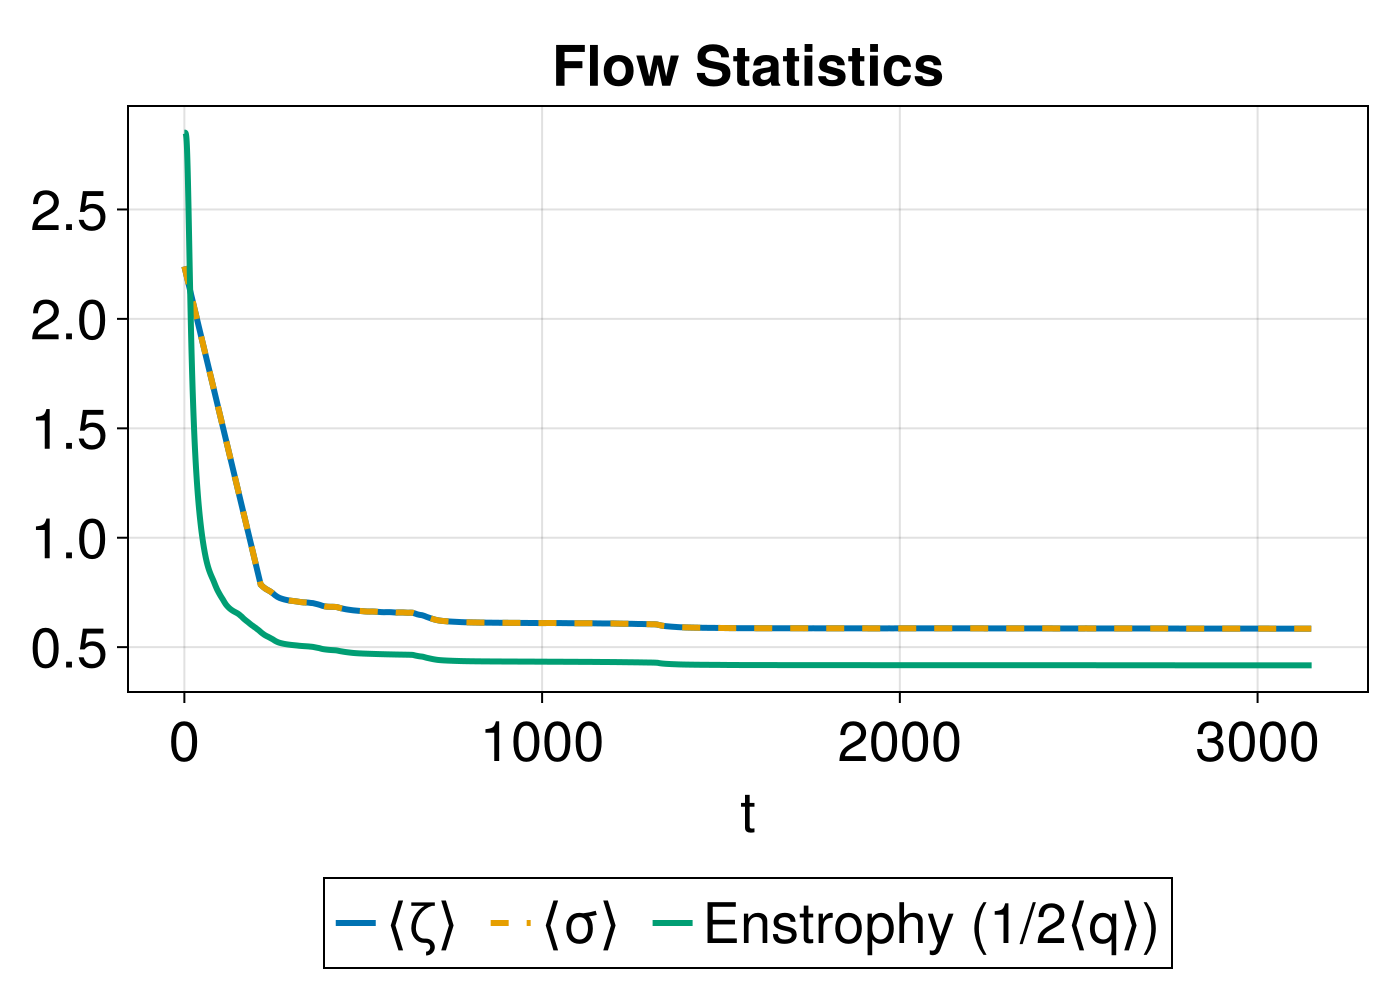

In [61]:
# Create plots of each field
stats_fig = Figure(size=(700, 500), fontsize=28)
ax = Axis(stats_fig[1,1], title="Flow Statistics", xlabel="t")
lines!(ax, t_snap, rms_ζ / grid.Lx, label="⟨ζ⟩", linewidth=3, linestyle=:solid)
lines!(ax, t_snap, rms_σ / grid.Lx, label="⟨σ⟩", linewidth=3, linestyle=:dash)
lines!(ax, diag_t, Z, label="Enstrophy (1/2⟨q⟩)", linewidth=3)
#lines!(diag_t, Z)
Legend(stats_fig[2,1], ax, orientation = :horizontal)


save("statistics.png", stats_fig)
stats_fig

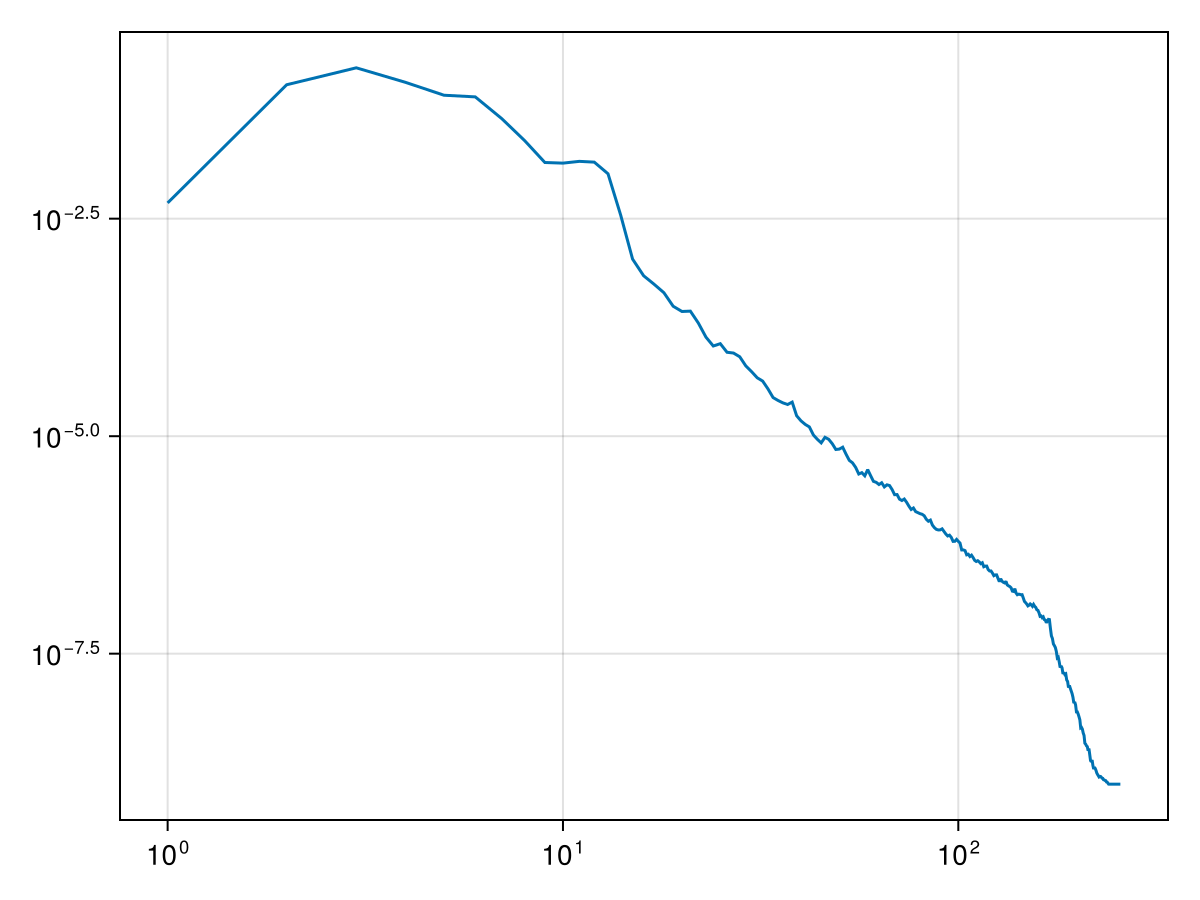

In [36]:
scale_factor = grid.dx * grid.dy / grid.nx / grid.ny
lines(ρ, scale_factor * radial_energies[10,:] .+ 1e-9; axis=(;yscale=log10, xscale=log10))

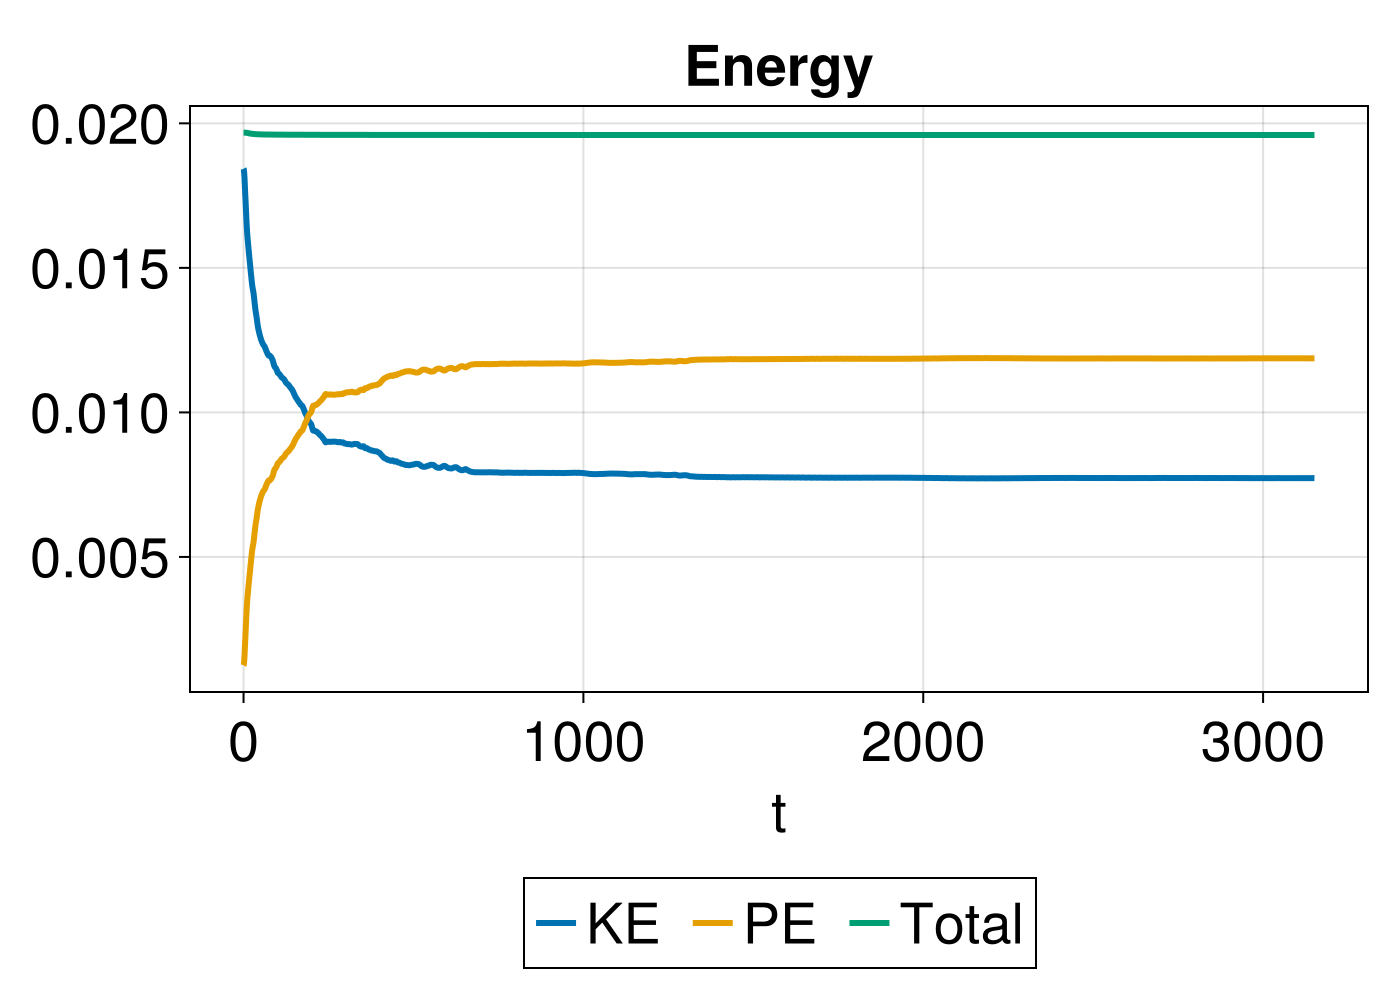

In [62]:
energy_fig = Figure(size=(700, 500), fontsize=28)
ax = Axis(energy_fig[1,1], title="Energy", xlabel="t")
lines!(ax, diag_t, KE, label="KE", linewidth=3)
lines!(ax, diag_t, PE, label="PE", linewidth=3)
lines!(ax, diag_t, KE+PE, label="Total", linewidth=3)
#lines!(diag_t, Z)
Legend(energy_fig[2,1], ax, orientation = :horizontal)


save("energy_diag.png", energy_fig)
energy_fig

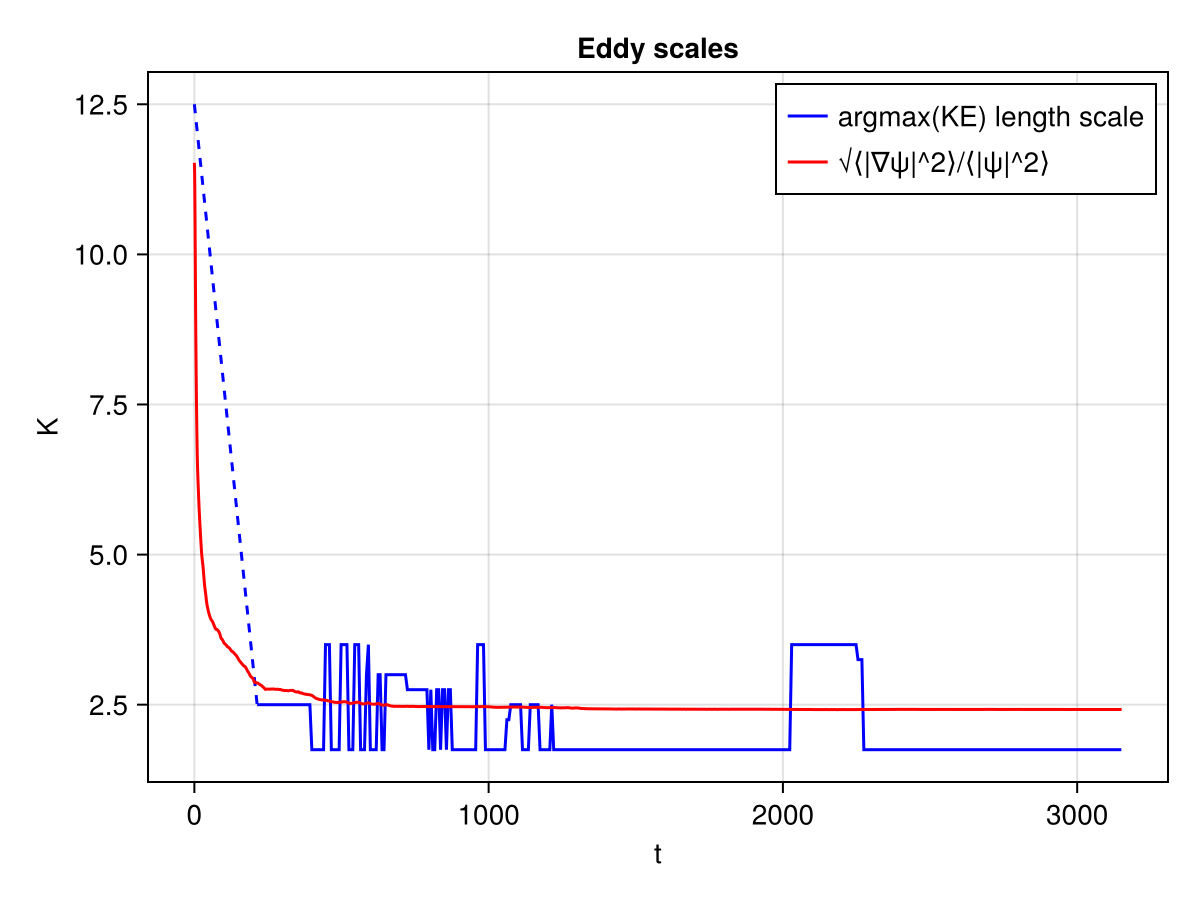

In [117]:
eddy_wavenumber_scale = sqrt.(KE ./ (PE/params.Kd2))

snapshot_eddy_wavenumber = ρ[argmax.(eachrow(radial_kinetic_energies))]
snapshot_eddy_wavenumber = ρ[argmax.(eachrow(radial__kinetic_energies))]
eddy_scale_fig = Figure()
ax = Axis(eddy_scale_fig[1,1]; title="Eddy scales", xlabel="t", ylabel="K")
lines!(t_snap[1:2], snapshot_eddy_scale[1:2], color=:blue, linestyle=:dash)
lines!(t_snap[2:end], snapshot_eddy_scale[2:end], label = "argmax(KE) length scale", color=:blue)
lines!(t_snap[2:end], snapshot_eddy_scale[2:end], label = "argmax(KE) length scale", color=:green)
lines!(diag_t, eddy_wavenumber_scale, label = "√⟨|∇ψ|^2⟩/⟨|ψ|^2⟩", color=:red)

axislegend(ax, position=:rt)
save("eddy_scales_with_total_energy.png", eddy_scale_fig)
eddy_scale_fig

In [91]:
KE[1]/(PE[1]/params.Kd2)

132.82144f0

In [73]:
eddy_wavenumber_scale/sqrt(params.Kd2)/2π

6356-element Vector{Float64}:
 44.27381145661578
 43.86231438082934
 42.68982172276639
 40.89780863397308
 38.65011511252785
 36.13106224954127
 33.52696922133657
 30.98434631491382
 28.594112936621116
 26.463341480284456
 24.667233873783623
 23.181633382877095
 21.86428175475886
  ⋮
  1.9526834474003762
  1.9527105498289916
  1.9527509491851325
  1.9528010671652143
  1.9528602233293952
  1.9529277373367546
  1.952997643121777
  1.9530598805315953
  1.9531059217160012
  1.9531270672836452
  1.9531209282007087
  1.9530875049817522

In [96]:
field = sin.(3*grid.x .+ 4*grid.y')
fieldh = zeros(Complex{Float64}, grid.nkr, grid.nl)
fieldh = mul!(fieldh, grid.rfftplan, field)

257×512 Matrix{ComplexF64}:
  8.71751e-12+0.0im          …   8.96685e-12-5.4077e-11im
  9.32701e-12+7.60484e-11im       9.5958e-12+2.02662e-11im
  1.27025e-11+2.43538e-10im      1.29519e-11+1.62351e-10im
   8.95209e-5+0.00364668im        8.95209e-5+0.00291701im
 -2.67047e-12-3.47906e-10im     -2.42113e-12-3.01474e-10im
  9.50617e-13-1.9038e-10im   …   1.16078e-12-1.72445e-10im
  2.07445e-12-1.35267e-10im      2.32379e-12-1.26225e-10im
  2.63273e-12-1.06541e-10im      2.87074e-12-1.01404e-10im
  2.92125e-12-8.84975e-11im      3.17059e-12-8.5528e-11im
   3.1261e-12-7.60735e-11im      3.36044e-12-7.43448e-11im
  3.24253e-12-6.6834e-11im   …   3.49188e-12-6.5925e-11im
  3.37737e-12-5.97302e-11im      3.54339e-12-5.93015e-11im
  3.40282e-12-5.40327e-11im      3.65217e-12-5.4016e-11im
             ⋮               ⋱  
   3.7486e-12-1.63388e-13im  …   3.94227e-12-1.71736e-13im
  3.73402e-12-2.32386e-13im      3.98337e-12-2.26856e-13im
  3.75455e-12-2.11117e-13im      4.02578e-12-2.23533e-13im


In [98]:
parsevalsum2(fieldh, grid)

19.739209900765772

In [104]:
fxh = grid.kr .* fieldh
fyh = grid.l  .* fieldh
sqrt(sum(abs2.(fxh) + abs2.(fyh))/sum(abs2.(fieldh)))

4.999999860863701